In [8]:
!pip install tslearn

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy import stats
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw, dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [10]:
df = pd.read_excel("/content/PENILAIAN PEGAWAI.xlsx")

In [11]:
df_mean = df.groupby("PEGAWAI").mean(numeric_only=True).reset_index()

In [12]:
pivot_df = df.pivot_table(
    index="PEGAWAI",
    columns="BULAN",
    values="NILAI AKHIR PERILAKU KERJA"
)
pivot_df = pivot_df.fillna(method='ffill').fillna(method='bfill')

In [13]:
cols_drop = [
    "BULAN", "PERANGKAT DAERAH", "SUB PERANGKAT DAERAH", "PEGAWAI", "NIP", "JABATAN",
    "NILAI BIAYA", "NILAI MUTU", "NILAI WAKTU", "NILAI AKHIR KINERJA INDIVIDU"
]
df_clust = df.drop(columns=cols_drop)

In [14]:
rename_dict = {
    "NILAI INTEGRITAS": "Integrity_Score",
    "NILAI KOMITMEN": "Commitment_Score",
    "NILAI KERJASAMA": "Teamwork_Score",
    "NILAI KEPEMIMPINAN": "Leadership_Score",
    "NILAI INISATIF KERJA": "Work_Initiative_Score",
    "NILAI ORIENTASI PELAYANAN": "Service_Orientation_Score",
    "NILAI KOMUNIKASI": "Communication_Score",
    "NILAI PENGEMBANGAN DIRI DAN ORANG LAIN": "Self_and_Others_Development_Score",
    "NILAI PENGAMBILAN KEPUTUSAN": "Decision_Making_Score",
    "NILAI PEREKAT BANGSA": "National_Unity_Score",
    "NILAI AKHIR PERILAKU KERJA": "Final_Work_Behavior_Score"
}

df_clust.rename(columns=rename_dict, inplace=True)

In [15]:
X = df_clust.drop(columns=["Final_Work_Behavior_Score"])
y = df_clust["Final_Work_Behavior_Score"]

In [16]:
print(df_clust.isna().sum())

Integrity_Score                      0
Commitment_Score                     0
Teamwork_Score                       0
Leadership_Score                     0
Work_Initiative_Score                0
Service_Orientation_Score            0
Communication_Score                  0
Self_and_Others_Development_Score    0
Decision_Making_Score                0
National_Unity_Score                 0
Final_Work_Behavior_Score            0
dtype: int64


In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,Integrity_Score,Commitment_Score,Teamwork_Score,Leadership_Score,Work_Initiative_Score,Service_Orientation_Score,Communication_Score,Self_and_Others_Development_Score,Decision_Making_Score,National_Unity_Score
0,-6.433067,-6.264164,-5.721058,-5.728261,-6.097646,-5.727100,-5.508328,-5.531565,-5.912745,-5.727831
1,0.312002,0.322756,0.325724,0.323080,0.315470,0.322864,0.334749,0.324346,0.319726,0.321633
2,-0.343768,-0.278933,-0.364398,-0.321520,-0.293776,-0.334740,-0.315957,-0.327790,-0.329490,-0.322767
3,-0.031497,-0.025590,-0.035768,-0.038685,-0.037251,-0.038818,-0.030443,-0.041649,-0.037343,-0.040020
4,0.249548,0.259421,0.259998,0.257304,0.251339,0.257104,0.268351,0.257801,0.254804,0.255878


In [18]:
X_scaled["Average Soft Skills Score"] = X_scaled[[
    "Integrity_Score", "Commitment_Score", "Teamwork_Score",
    "Leadership_Score", "Work_Initiative_Score", "Service_Orientation_Score", "Communication_Score",
    "Self_and_Others_Development_Score", "Decision_Making_Score", "National_Unity_Score"
]].mean(axis=1)

In [19]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

Outlier Count per Column:
Integrity_Score                      13
Commitment_Score                     10
Teamwork_Score                       13
Leadership_Score                     10
Work_Initiative_Score                10
Service_Orientation_Score            10
Communication_Score                  13
Self_and_Others_Development_Score    10
Decision_Making_Score                10
National_Unity_Score                 10
Average Soft Skills Score            10
dtype: int64


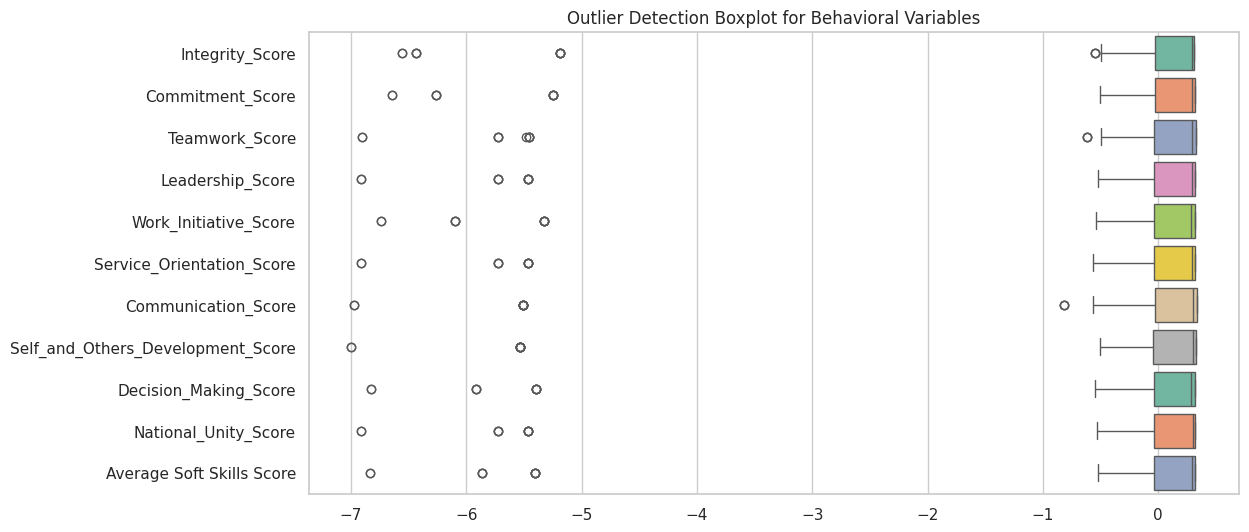

In [20]:
Q1 = X_scaled.quantile(0.25)
Q3 = X_scaled.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_summary = ((X_scaled < lower_bound) | (X_scaled > upper_bound)).sum()
print("Outlier Count per Column:")
print(outlier_summary)

plt.figure(figsize=(12, 6))
sns.boxplot(data=X_scaled, orient="h", palette="Set2")
plt.title("Outlier Detection Boxplot for Behavioral Variables")
plt.show()

In [21]:
def handle_outliers(df):
    df_handled = df.copy()
    for col in df.columns:
        if df[col].dtype in ["float64", "int64"]:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            df_handled[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df_handled[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df_handled

X_no_outlier = handle_outliers(X_scaled)

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd

inertias = []
sil_scores = []
db_scores = []

K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_no_outlier)

    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_no_outlier, labels))
    db_scores.append(davies_bouldin_score(X_no_outlier, labels))

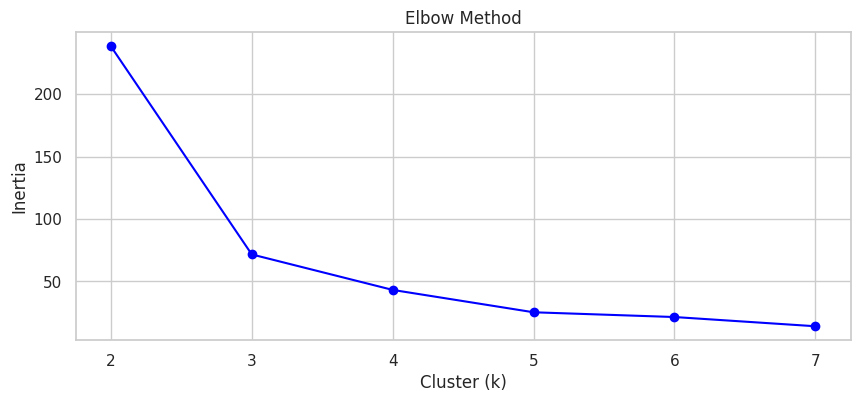

In [23]:
#Elbow method
plt.figure(figsize=(10,4))
plt.plot(K_range, inertias, 'o-', color='blue')
plt.title("Elbow Method")
plt.xlabel("Cluster (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

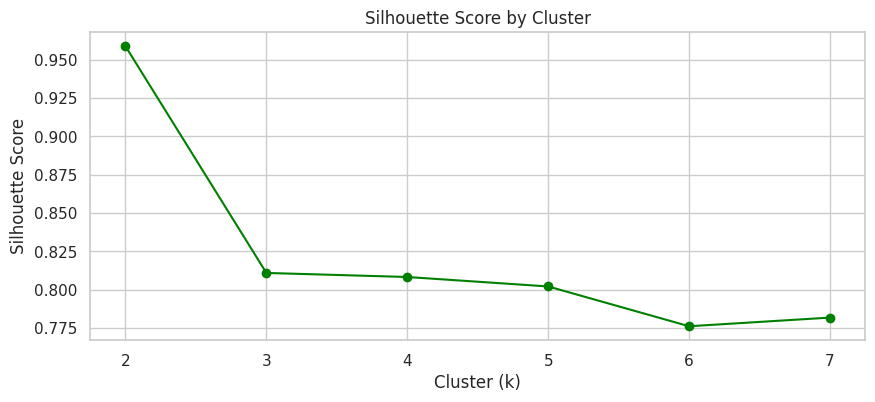

In [24]:
#Silhouette score
plt.figure(figsize=(10,4))
plt.plot(K_range, sil_scores, 'o-', color='green')
plt.title("Silhouette Score by Cluster")
plt.xlabel("Cluster (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [25]:
k_final = 3

In [26]:
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)
X_pca["Cluster"] = clusters

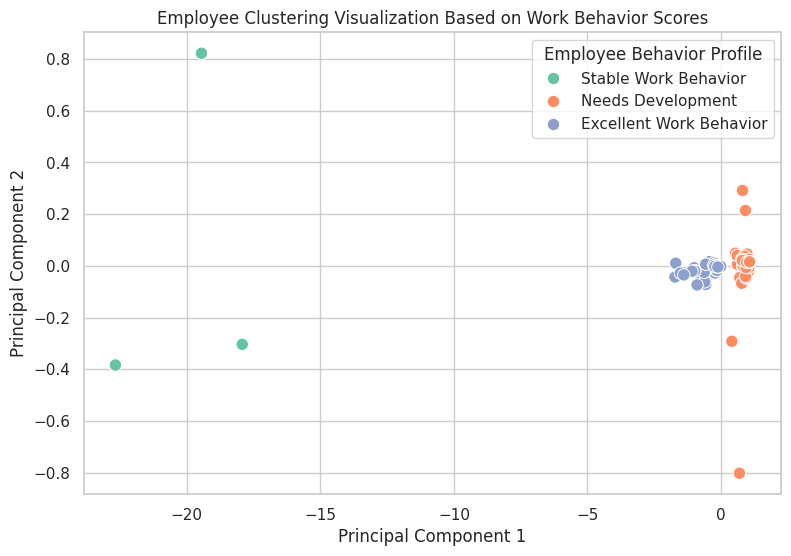

In [27]:
label_map = {
    0: "Excellent Work Behavior",
    1: "Stable Work Behavior",
    2: "Needs Development"
}

X_pca["Interpretation Labels"] = X_pca["Cluster"].map(label_map)

plt.figure(figsize=(9,6))
sns.scatterplot(
    data=X_pca,
    x="PC1", y="PC2",
    hue="Interpretation Labels",
    palette="Set2",
    s=80
)
plt.title("Employee Clustering Visualization Based on Work Behavior Scores")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Employee Behavior Profile", loc="best")
plt.show()

In [28]:
silhouette_avg = silhouette_score(X_pca[["PC1", "PC2"]], X_pca["Cluster"])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.8290


In [29]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

hc = AgglomerativeClustering(n_clusters=k_final, metric='euclidean', linkage='ward')
clusters_hc = hc.fit_predict(X_pca[["PC1", "PC2"]])
X_pca["Cluster_HC"] = clusters_hc

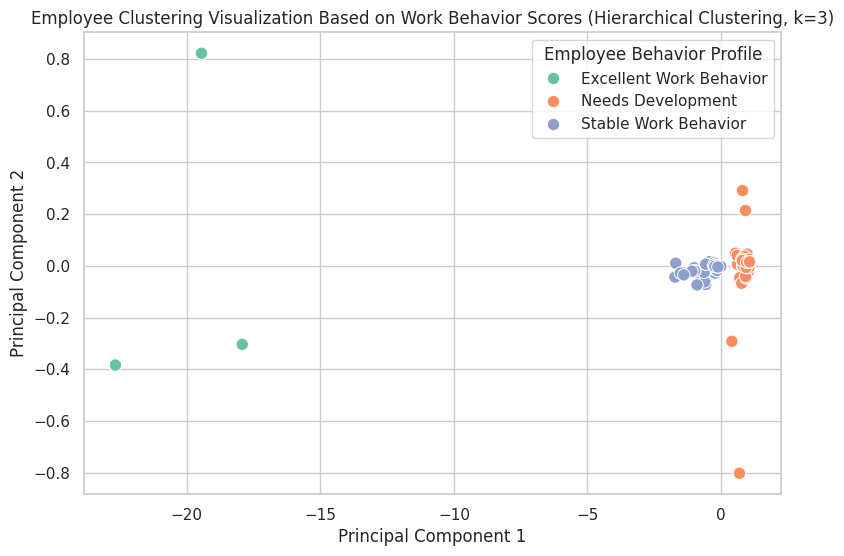

In [30]:
label_map_hc = {
    0: "Excellent Work Behavior",
    1: "Stable Work Behavior",
    2: "Needs Development"
}
X_pca["Interpretation Labels HC"] = X_pca["Cluster_HC"].map(label_map_hc)

plt.figure(figsize=(9,6))
sns.scatterplot(
    data=X_pca,
    x="PC1", y="PC2",
    hue="Interpretation Labels HC",
    palette="Set2",
    s=80
)
plt.title("Employee Clustering Visualization Based on Work Behavior Scores (Hierarchical Clustering, k=3)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Employee Behavior Profile", loc="best")
plt.show()

In [31]:
silhouette_avg_hc = silhouette_score(X_pca[["PC1", "PC2"]], X_pca["Cluster_HC"])
print(f"Silhouette Score : {silhouette_avg_hc:.4f}")

Silhouette Score : 0.8290


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
X = X_no_outlier[
    [
        "Integrity_Score",
        "Commitment_Score",
        "Teamwork_Score",
        "Leadership_Score",
        "Work_Initiative_Score",
        "Service_Orientation_Score",
        "Communication_Score",
        "Self_and_Others_Development_Score",
        "Decision_Making_Score",
        "National_Unity_Score"
    ]
]

y = df_clust["Final_Work_Behavior_Score"]

In [34]:
df_clust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Integrity_Score                    371 non-null    float64
 1   Commitment_Score                   371 non-null    float64
 2   Teamwork_Score                     371 non-null    float64
 3   Leadership_Score                   371 non-null    float64
 4   Work_Initiative_Score              371 non-null    float64
 5   Service_Orientation_Score          371 non-null    float64
 6   Communication_Score                371 non-null    float64
 7   Self_and_Others_Development_Score  371 non-null    float64
 8   Decision_Making_Score              371 non-null    float64
 9   National_Unity_Score               371 non-null    float64
 10  Final_Work_Behavior_Score          371 non-null    float64
dtypes: float64(11)
memory usage: 32.0 KB


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

rf = RandomForestRegressor(
    n_estimators=250,
    max_depth=None,
    min_samples_leaf=4,
    min_samples_split=8,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

In [37]:
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

print(f"R² (Train): {r2_train:.3f}")
print(f"MAE (Train): {mae_train:.3f}")
print(f"RMSE (Train): {rmse_train:.3f}")

R² (Train): 0.976
MAE (Train): 0.039
RMSE (Train): 0.207


In [38]:
y_pred_test = rf.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R² (Test): {r2_test:.3f}")
print(f"MAE (Test): {mae_test:.3f}")
print(f"RMSE (Test): {rmse_test:.3f}")

R² (Test): 0.967
MAE (Test): 0.104
RMSE (Test): 0.393


In [39]:
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Ranking of Key Features Affecting Final Work Behavior Score")
print(feature_importances)

Ranking of Key Features Affecting Final Work Behavior Score
                             Feature  Importance
5          Service_Orientation_Score    0.119981
4              Work_Initiative_Score    0.116885
9               National_Unity_Score    0.116699
0                    Integrity_Score    0.105981
8              Decision_Making_Score    0.104753
3                   Leadership_Score    0.100378
2                     Teamwork_Score    0.098871
1                   Commitment_Score    0.090559
6                Communication_Score    0.080308
7  Self_and_Others_Development_Score    0.065585


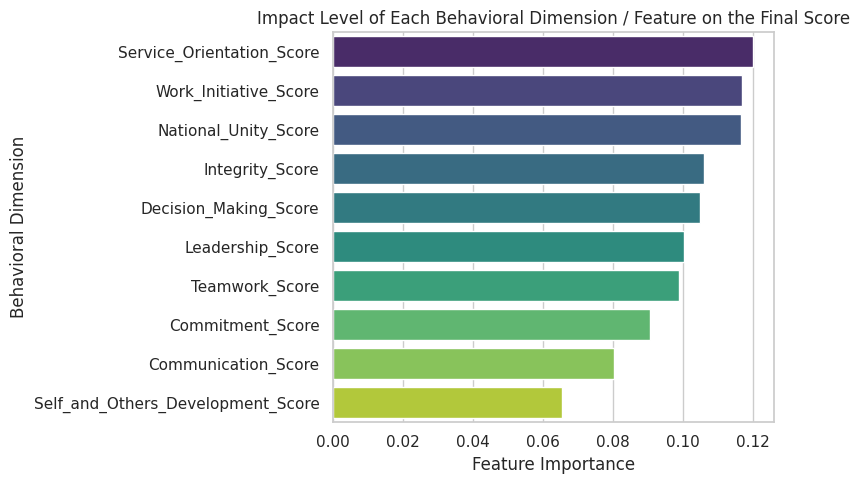

In [40]:
plt.figure(figsize=(8,5))
sns.barplot(data=feature_importances, x="Importance", y="Feature", palette="viridis")
plt.title("Impact Level of Each Behavioral Dimension / Feature on the Final Score")
plt.xlabel("Feature Importance")
plt.ylabel("Behavioral Dimension")
plt.tight_layout()
plt.show()

In [44]:
y = df_clust['Final_Work_Behavior_Score']
x = df_clust[[
    'Integrity_Score',
    'Commitment_Score',
    'Teamwork_Score',
    'Leadership_Score',
    'Work_Initiative_Score',
    'Service_Orientation_Score',
    'Communication_Score',
    'Self_and_Others_Development_Score',
    'Decision_Making_Score',
    'National_Unity_Score'
]]

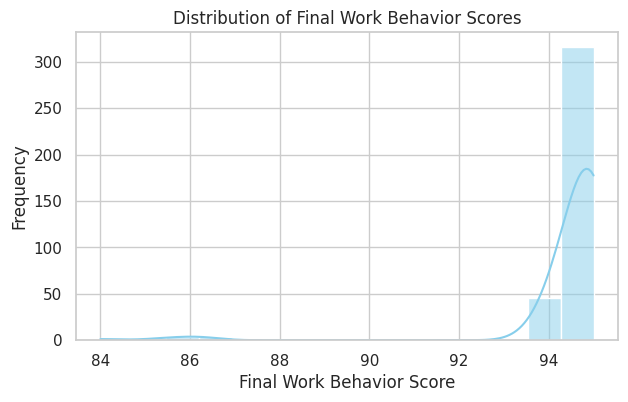

In [45]:
plt.figure(figsize=(7, 4))
sns.histplot(y, kde=True, bins=15, color='skyblue')
plt.title("Distribution of Final Work Behavior Scores", fontsize=12)
plt.xlabel("Final Work Behavior Score")
plt.ylabel("Frequency")
plt.show()

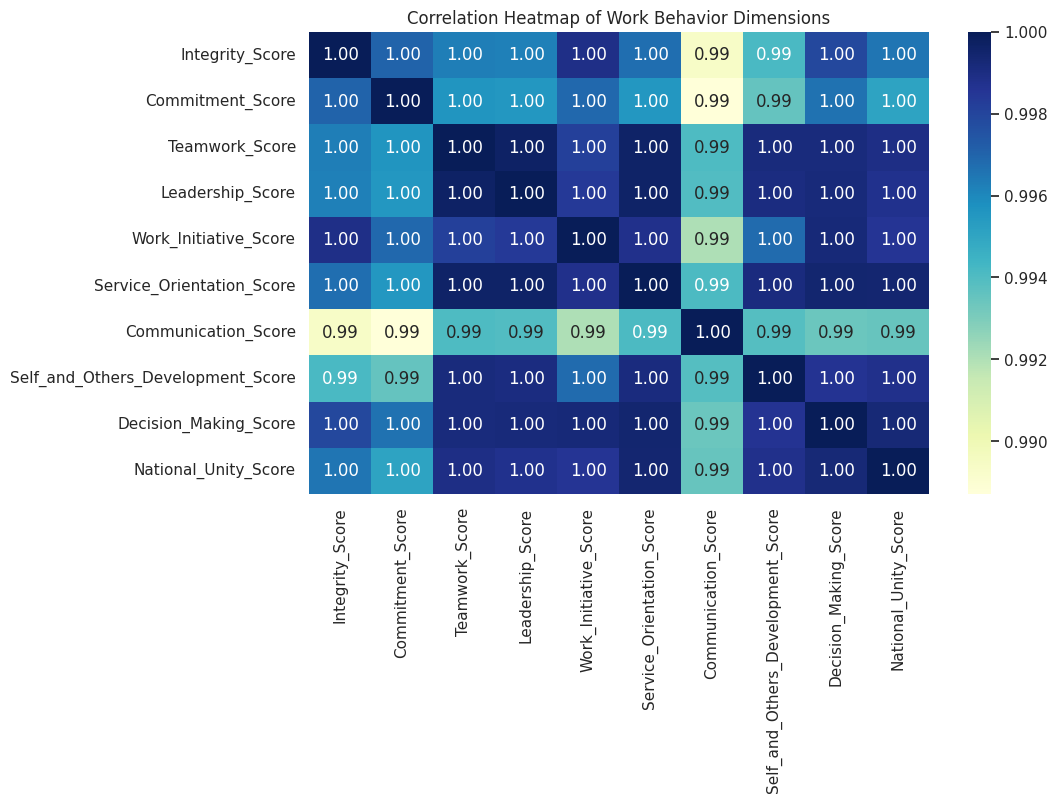

In [46]:
plt.figure(figsize=(10, 6))
sns.heatmap(x.corr(), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap of Work Behavior Dimensions", fontsize=12)
plt.show()

In [47]:
#Residual Normality Test (shapiro-wilk test)
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_train = linreg.predict(X_train)
residuals = y_train - y_pred_train

stat, p_value = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test Statistic: {stat:.3f}")
print(f"p-value: {p_value:.3f}")

Shapiro-Wilk Test Statistic: 0.755
p-value: 0.000


In [48]:
#Homoscedasticity Test (gletser)
import statsmodels.api as sm
abs_resid = np.abs(residuals)
X_train_const = sm.add_constant(X_train)
glejser_model = sm.OLS(abs_resid, X_train_const).fit()

print(glejser_model.summary())

                                OLS Regression Results                               
Dep. Variable:     Final_Work_Behavior_Score   R-squared:                       0.081
Model:                                   OLS   Adj. R-squared:                  0.049
Method:                        Least Squares   F-statistic:                     2.518
Date:                       Thu, 29 Jan 2026   Prob (F-statistic):            0.00645
Time:                               01:04:47   Log-Likelihood:                 1531.5
No. Observations:                        296   AIC:                            -3041.
Df Residuals:                            285   BIC:                            -3000.
Df Model:                                 10                                         
Covariance Type:                   nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [49]:
#Residual Independence Test (Durbin-Watson)
from statsmodels.stats.stattools import durbin_watson

dw_value = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_value:.3f}")

Durbin-Watson Statistic: 1.910


In [50]:
#Multicollinearity Test (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                   for i in range(X_train.shape[1])]

print(vif_data)

                             Feature          VIF
0                    Integrity_Score   752.133103
1                   Commitment_Score   141.934193
2                     Teamwork_Score  1782.151931
3                   Leadership_Score  1789.409201
4              Work_Initiative_Score  1524.403030
5          Service_Orientation_Score  2908.429097
6                Communication_Score    80.027497
7  Self_and_Others_Development_Score  1011.080720
8              Decision_Making_Score  2238.552460
9               National_Unity_Score   957.745195


In [51]:
from sklearn.linear_model import LassoCV
scaler_for_lasso = StandardScaler()
X_train_scaled = scaler_for_lasso.fit_transform(X_train)
X_test_scaled = scaler_for_lasso.transform(X_test)

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)

y_pred_train_lasso = lasso.predict(X_train_scaled)
y_pred_test_lasso = lasso.predict(X_test_scaled)

In [52]:
r2_train_lasso = r2_score(y_train, y_pred_train_lasso)
r2_test_lasso = r2_score(y_test, y_pred_test_lasso)
mae_test_lasso = mean_absolute_error(y_test, y_pred_test_lasso)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_test_lasso))

print(f"Alpha (Lasso)     : {lasso.alpha_:.6f}")
print(f"R² Train (Lasso)  : {r2_train_lasso:.4f}")
print(f"R² Test (Lasso)   : {r2_test_lasso:.4f}")
print(f"MAE Test (Lasso)  : {mae_test_lasso:.4f}")
print(f"RMSE Test (Lasso) : {rmse_test_lasso:.4f}")

Alpha (Lasso)     : 0.001322
R² Train (Lasso)  : 0.9999
R² Test (Lasso)   : 1.0000
MAE Test (Lasso)  : 0.0062
RMSE Test (Lasso) : 0.0104


In [53]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Lasso Coefficients": lasso.coef_
})

coefficients_sorted = coefficients.reindex(
    coefficients["Lasso Coefficients"]
    .abs()
    .sort_values(ascending=False)
    .index
)

print("Effect of Each Variable on Final Work Behavior Score:")
print(coefficients_sorted)

Effect of Each Variable on Final Work Behavior Score:
                             Feature  Lasso Coefficients
2                     Teamwork_Score            0.390819
3                   Leadership_Score            0.176953
4              Work_Initiative_Score            0.176597
0                    Integrity_Score            0.134935
6                Communication_Score            0.121657
1                   Commitment_Score            0.112955
7  Self_and_Others_Development_Score            0.084300
9               National_Unity_Score            0.071834
8              Decision_Making_Score            0.053245
5          Service_Orientation_Score            0.000000


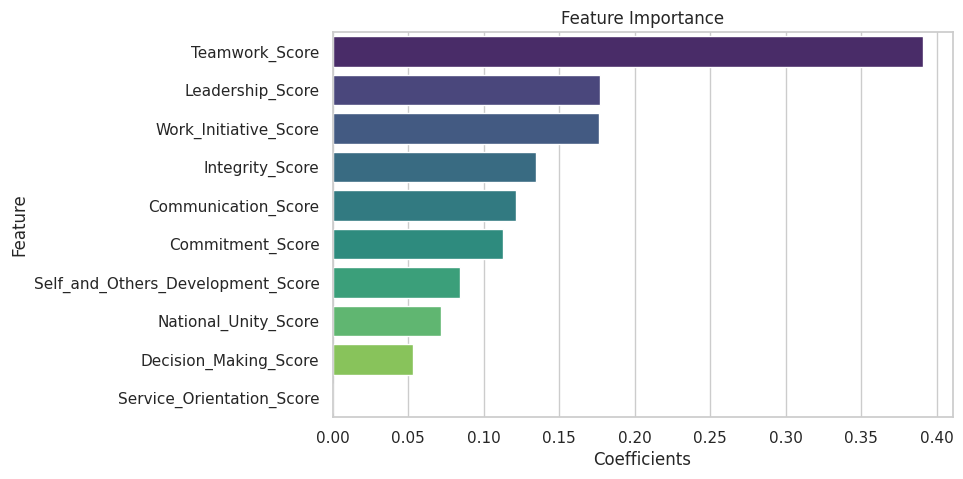

In [54]:
plt.figure(figsize=(8,5))
sns.barplot(
    x='Lasso Coefficients',
    y='Feature',
    data=coefficients_sorted,
    palette='viridis'
)
plt.title('Feature Importance', fontsize=12)
plt.xlabel('Coefficients')
plt.ylabel('Feature')
plt.show()